In [1]:
from __future__ import print_function
from pyspark import SparkContext , SparkConf
import sys
from operator import add
from csv import reader
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg
from pyspark.sql.functions import col, count, avg, when, desc

import matplotlib.pyplot as plt
import seaborn as sns 


In [2]:
cf = SparkConf()
cf.set("spark.submit.deployMode","client")

sc = SparkContext.getOrCreate(cf)

spark = SparkSession.builder.appName("Task1A").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 03:47:30 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/12 03:47:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/12 03:47:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/12 03:47:30 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
file_path = "project/project/data/matches/*/*.json"

In [4]:
match_df = spark.read.option("multiline","true").json(file_path)

In [5]:
match_df.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team: struct (nullable = true)
 |    |-- away_team_gender: string (nullable = true)
 |    |-- away_team_group: string (nullable = true)
 |    |-- away_team_id: long (nullable = true)
 |    |-- away_team_name: string (nullable = true)
 |    |-- country: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- managers: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- country: struct (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- dob: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- nickname: string (nullable = true)
 |-- competition: struct (nullable = true)
 |    |-- competition_id: long (nullable = true)
 |    |-- competition_nam

In [6]:
from pyspark.sql.functions import count

# Count the matches in each season
matches_count_by_season = (
    match_df.groupBy("competition.competition_name")
    .agg(count("match_id").alias("matches_count"))
    .orderBy(desc("matches_count"))
)

# Display the matches count in each season
matches_count_by_season.show()


+--------------------+-------------+
|    competition_name|matches_count|
+--------------------+-------------+
|             La Liga|          868|
|      Premier League|          418|
|             Serie A|          381|
|             Ligue 1|          377|
|FA Women's Super ...|          326|
|       1. Bundesliga|          306|
|      FIFA World Cup|          147|
|   Women's World Cup|          116|
| Indian Super league|          115|
|           UEFA Euro|           51|
|                NWSL|           36|
|   UEFA Women's Euro|           31|
|    Champions League|           17|
|        Copa del Rey|            3|
|  UEFA Europa League|            3|
|    Liga Profesional|            2|
|North American Le...|            1|
|  FIFA U20 World Cup|            1|
+--------------------+-------------+



In [7]:
from pyspark.sql.functions import count

# Count the matches in each season
matches_count_by_season = (
    match_df.groupBy("season.season_name")
    .agg(count("match_id").alias("matches_count"))
    .orderBy(desc("matches_count"))
)

# Display the matches count in each season
matches_count_by_season.show()


+-----------+-------------+
|season_name|matches_count|
+-----------+-------------+
|  2015/2016|         1824|
|  2020/2021|          166|
|  2018/2019|          143|
|  2019/2020|          120|
|  2021/2022|          115|
|       2018|          100|
|       2022|           95|
|       2023|           64|
|       2019|           52|
|       2020|           51|
|  2003/2004|           39|
|  2014/2015|           39|
|  2011/2012|           38|
|  2017/2018|           37|
|  2009/2010|           36|
|  2016/2017|           35|
|  2010/2011|           34|
|  2012/2013|           33|
|  2008/2009|           32|
|  2013/2014|           32|
+-----------+-------------+
only showing top 20 rows



# selected_season

In [8]:
selected_season = "2015/2016"
selected_season_data = match_df.filter(match_df.season.season_name == selected_season)

In [9]:
home_advantage_df = (
    selected_season_data.withColumn("home_advantage", col("home_score") - col("away_score"))
    .select("home_advantage")
    .toPandas()
)

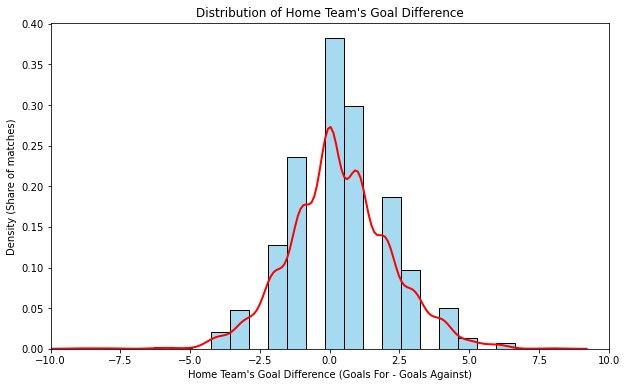

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(home_advantage_df['home_advantage'], bins=25, color='skyblue', stat='density')
sns.kdeplot(home_advantage_df['home_advantage'], color='red', linewidth=2)
plt.title('Distribution of Home Team\'s Goal Difference')
plt.xlabel('Home Team\'s Goal Difference (Goals For - Goals Against)')
plt.ylabel('Density (Share of matches)')
plt.xlim(-10,10)
plt.show()

In [11]:
from pyspark.sql.functions import expr

win_conditions = [
    expr("CASE WHEN home_score > away_score THEN 1 ELSE 0 END").alias("home_win"),
    expr("CASE WHEN home_score < away_score THEN 1 ELSE 0 END").alias("away_win"),
]

win_percentage_df = selected_season_data.select("*", *win_conditions)

home_win_percentage = win_percentage_df.agg(avg("home_win")).first()[0]
away_win_percentage = win_percentage_df.agg(avg("away_win")).first()[0]

print("Home Win Percentage:", home_win_percentage)
print("Away Win Percentage:", away_win_percentage)


Home Win Percentage: 0.4440789473684211
Away Win Percentage: 0.29605263157894735


In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col

mean_home_scores = (
    selected_season_data.groupBy("home_team.home_team_name", "home_team.country.name")
    .agg(avg("home_score").alias("mean_home_score"))
)

# Calculate mean away scores for each away team
mean_away_scores = (
    selected_season_data.groupBy("away_team.away_team_name")
    .agg(avg("away_score").alias("mean_away_score"))
)

mean_home_scores = mean_home_scores.withColumnRenamed("home_team_name", "team_name")
mean_home_scores = mean_home_scores.withColumnRenamed("name", "country_name")
mean_away_scores = mean_away_scores.withColumnRenamed("away_team_name", "team_name")

team_scores_df = mean_home_scores.join(mean_away_scores, "team_name", "inner")
team_scores_df = team_scores_df.filter(col("country_name") != "Wales")
team_scores_df = team_scores_df.filter(col("country_name") != "Monaco")

# Display the resulting table
team_scores_df.show(truncate=False)


+-----------------+------------+------------------+------------------+
|team_name        |country_name|mean_home_score   |mean_away_score   |
+-----------------+------------+------------------+------------------+
|Manchester United|England     |1.4210526315789473|1.1578947368421053|
|Guingamp         |France      |1.631578947368421 |0.8421052631578947|
|Toulouse         |France      |1.5263157894736843|0.8421052631578947|
|Hamburger SV     |Germany     |1.1764705882352942|1.1764705882352942|
|Wolfsburg        |Germany     |1.8823529411764706|0.8823529411764706|
|Bayern Munich    |Germany     |3.0               |1.7058823529411764|
|Troyes           |France      |0.6111111111111112|0.7894736842105263|
|Angers           |France      |1.0526315789473684|1.0526315789473684|
|Southampton      |England     |2.0526315789473686|1.0526315789473684|
|Stade de Reims   |France      |1.4736842105263157|0.8421052631578947|
|Sevilla          |Spain       |2.0               |0.6842105263157895|
|Udine

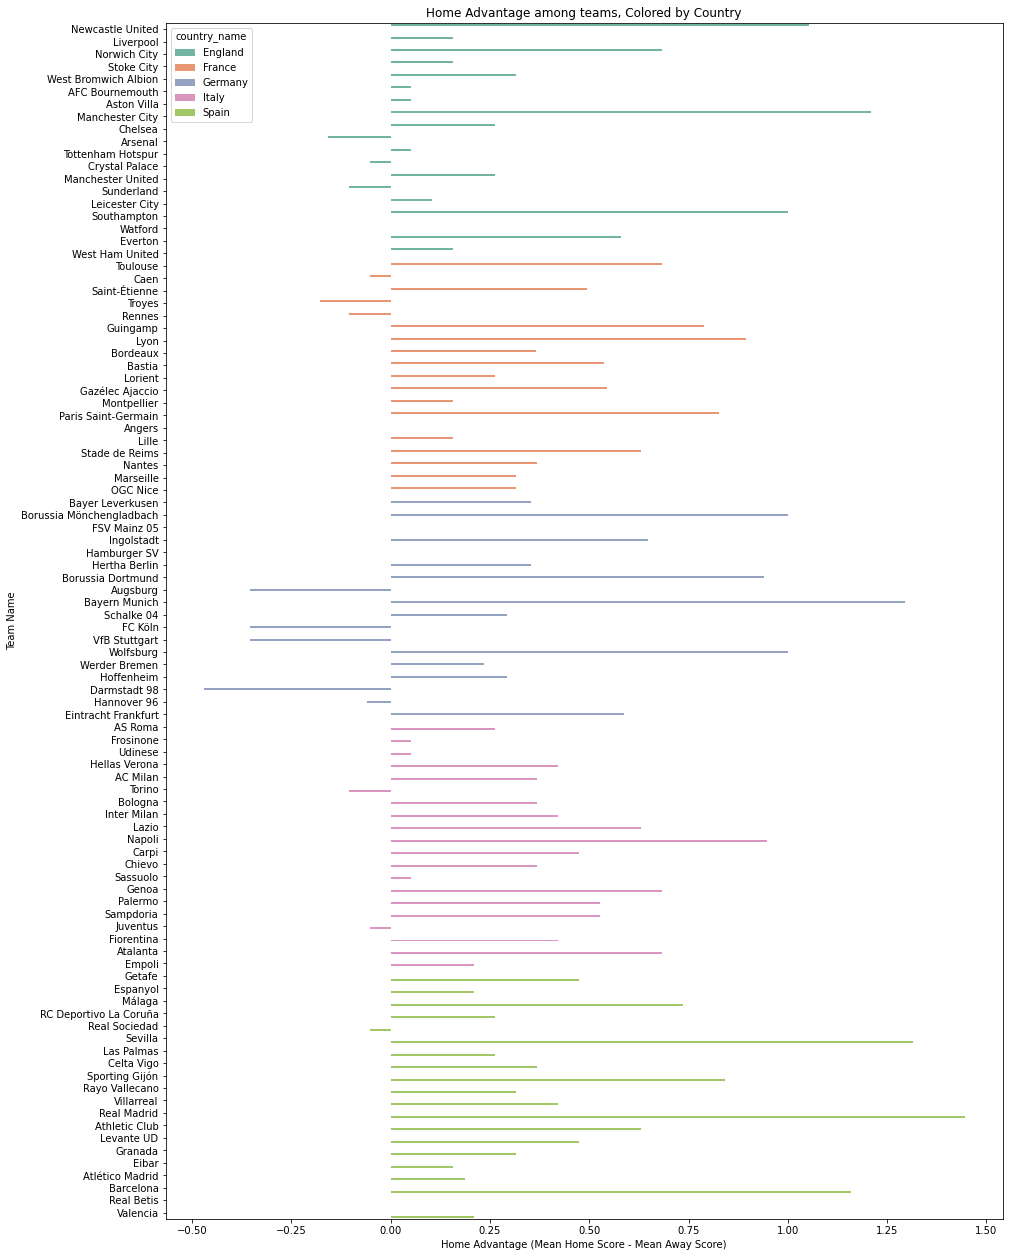

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col

pandas_df = team_scores_df.toPandas()

pandas_df['score_difference'] = pandas_df['mean_home_score'] - pandas_df['mean_away_score']

pandas_df = pandas_df.sort_values(by=['country_name'])

plt.figure(figsize=(15, 22))
sns.barplot(x='score_difference', y='team_name', hue='country_name', data=pandas_df , palette='Set2')

plt.xlabel('Home Advantage (Mean Home Score - Mean Away Score)')
plt.ylabel('Team Name')
plt.title('Home Advantage among teams, Colored by Country')

plt.show()


# General Play Style 

In [14]:
from pyspark.sql.functions import avg, col

mean_home_scores = (
    selected_season_data.groupBy("home_team.home_team_name", "home_team.country.name")
    .agg(avg("home_score").alias("mean_home_score"), avg("away_score").alias("mean_away_score"))
)

# Calculate mean away scores for each away team
mean_away_scores = (
    selected_season_data.groupBy("away_team.away_team_name")
    .agg(avg("away_score").alias("mean_away_score"), avg("home_score").alias("mean_home_score"))
)

mean_home_scores = mean_home_scores.withColumnRenamed("home_team_name", "team_name")
mean_home_scores = mean_home_scores.withColumnRenamed("mean_home_score", "home_Attacking")
mean_home_scores = mean_home_scores.withColumnRenamed("mean_away_score", "home_Defensive")
mean_home_scores = mean_home_scores.withColumnRenamed("name", "country_name")
mean_away_scores = mean_away_scores.withColumnRenamed("away_team_name", "team_name")
mean_away_scores = mean_away_scores.withColumnRenamed("mean_home_score", "away_Defensive")
mean_away_scores = mean_away_scores.withColumnRenamed("mean_away_score", "away_Attacking")


team_scores_df = mean_home_scores.join(mean_away_scores, "team_name", "inner")
team_scores_df = team_scores_df.filter(col("country_name") != "Wales")
team_scores_df = team_scores_df.filter(col("country_name") != "Monaco")


team_scores_df.show(truncate=False)


+----------------------+------------+------------------+-------------------+------------------+------------------+
|team_name             |country_name|home_Attacking    |home_Defensive     |away_Attacking    |away_Defensive    |
+----------------------+------------+------------------+-------------------+------------------+------------------+
|RC Deportivo La Coruña|Spain       |1.3157894736842106|1.7894736842105263 |1.0526315789473684|1.4210526315789473|
|Palermo               |Italy       |1.263157894736842 |1.5789473684210527 |0.7368421052631579|1.8421052631578947|
|Málaga                |Spain       |1.368421052631579 |0.7894736842105263 |0.631578947368421 |1.0526315789473684|
|Espanyol              |Spain       |1.1578947368421053|1.4736842105263157 |0.9473684210526315|2.4210526315789473|
|Carpi                 |Italy       |1.2105263157894737|1.368421052631579  |0.7368421052631579|1.631578947368421 |
|Inter Milan           |Italy       |1.5263157894736843|0.7894736842105263 |1.10

In [15]:
Attacking_difference = team_scores_df.orderBy((col('home_Attacking')-col('away_Attacking')).desc())
Defensive_difference = team_scores_df.orderBy((col('home_Defensive')-col('away_Defensive')))
attacking_diff = Attacking_difference.select(col('home_Attacking') - col('away_Attacking')).rdd.flatMap(lambda x: x).collect()
defensive_diff = Defensive_difference.select(col('home_Defensive') - col('away_Defensive')).rdd.flatMap(lambda x: x).collect()
countries = Attacking_difference.select("country_name").rdd.flatMap(lambda x: x).collect()

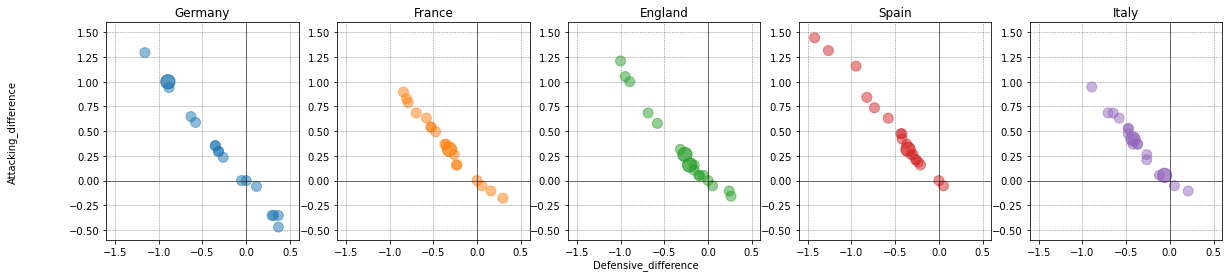

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
from pyspark.sql.functions import col

# Assuming you have already defined attacking_diff, defensive_diff, and countries

# Calculate the origin point
origin_attacking = 0
origin_defensive = 0

# Predefined list of distinct and obvious colors
distinct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a dictionary to store colors for each country
country_colors = {country: distinct_colors[i % len(distinct_colors)] for i, country in enumerate(set(countries))}

# Get unique countries for plotting individual graphs
unique_countries = list(set(countries))

# Set the same scale for all subplots
common_xlim = (-1.6, 0.6)
common_ylim = (-0.6, 1.6)

# Set the number of subplots per row
subplots_per_row = len(unique_countries)

# Plotting subplots in a row
fig, axs = plt.subplots(1, subplots_per_row, figsize=(4 * subplots_per_row, 4))
fig.subplots_adjust(hspace=0.5)

for i, country in enumerate(unique_countries):
    country_attacking_diff = [attacking_diff[j] for j in range(len(attacking_diff)) if countries[j] == country]
    country_defensive_diff = [defensive_diff[j] for j in range(len(defensive_diff)) if countries[j] == country]

    # Calculate marker size based on the number of overlapping points
    marker_size = [Counter(zip(country_defensive_diff, country_attacking_diff))[(x, y)] * 100 for x, y in zip(country_defensive_diff, country_attacking_diff)]

    axs[i].scatter(country_defensive_diff, country_attacking_diff, 
                   color=country_colors[country], s=marker_size, alpha=0.5)

    axs[i].set_title(f'{country}')
    
    # Set the same scale for all subplots
    axs[i].set_xlim(common_xlim)
    axs[i].set_ylim(common_ylim)

    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)
    axs[i].grid(color='gray', linestyle='--', linewidth=0.5)

# Set x and y labels for all subplots
fig.text(0.5, 0.04, 'Defensive_difference', ha='center', va='center')
fig.text(0.06, 0.5, 'Attacking_difference', ha='center', va='center', rotation='vertical')

# Display the subplots
plt.show()


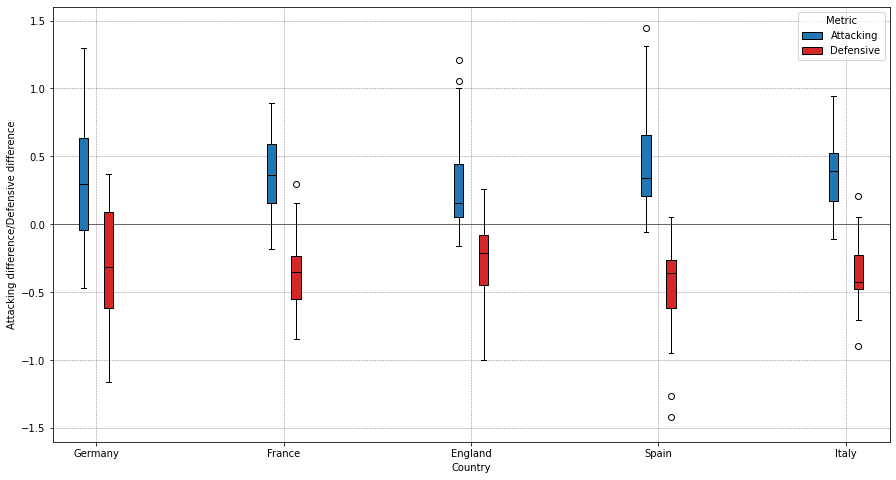

In [18]:

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Assuming you have already defined attacking_diff, defensive_diff, and countries

# Calculate the origin point
origin_attacking = 0
origin_defensive = 0

# Predefined colors for attacking and defensive
attacking_color = '#1f77b4'  # blue
defensive_color = '#d62728'  # red

# Create a dictionary to store colors for each country
country_colors = {country: [attacking_color, defensive_color] for country in set(countries)}

# Get unique countries for plotting individual graphs
unique_countries = list(set(countries))

# Set the same scale for all subplots
common_ylim = (-1.6, 1.6)

# Plotting in one subplot
fig, ax = plt.subplots(figsize=(15, 8))

# Collecting box plot artists for legend
box_plot_artists = []

# Set the x-axis ticks
x_ticks = np.arange(1, len(unique_countries) *3,3)  # Adjust the step to provide enough space

for i, country in enumerate(unique_countries):
    country_attacking_diff = [attacking_diff[j] for j in range(len(attacking_diff)) if countries[j] == country]
    country_defensive_diff = [defensive_diff[j] for j in range(len(defensive_diff)) if countries[j] == country]

    # Calculate box plot positions
    box_positions = [x_ticks[i] - 0.2, x_ticks[i] + 0.2]

    # Create a box plot for each country
    box_plot = ax.boxplot([country_attacking_diff, country_defensive_diff], 
                          positions=box_positions,
                          labels=[country, ''],  # Label only the first box in the group with the country name
                          patch_artist=True, 
                          boxprops=dict(facecolor=country_colors[country][0], color='black'),
                          medianprops=dict(color='black'))

    # Customize box colors
    for box, color in zip(box_plot['boxes'], country_colors[country]):
        box.set(facecolor=color)

    box_plot_artists.append(box_plot['boxes'])

# Set the same scale for all subplots
ax.set_ylim(common_ylim)
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.set_xticks(x_ticks)
ax.set_xticklabels(unique_countries)
# Adding legend
ax.legend(box_plot_artists[0], ['Attacking', 'Defensive'],title='Metric', loc='upper right',)

# Set x-axis label
ax.set_xlabel('Country')
ax.set_ylabel('Attacking difference/Defensive difference')

# Display the plot
plt.show()